<a href="https://colab.research.google.com/github/vorobevskaya/mashine_learning/blob/main/9_%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B8_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ансамбли моделей

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10264\1269238635.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdBu')


In [ ]:
from sklearn import set_config

set_config(display='diagram')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
        
    return (mae, mse, rmse, mape, r2)

# 1. Bootstrap

Пусть имеется выборка $X_1, \ldots, X_n$ из распределения $F(x)$.

__Задача:__ построить доверительный интервал для дисперсии.

In [ ]:
N = 256

np.random.seed(42)
Z = np.random.normal(size=N)
loc = np.random.normal(4, 1, size=N)
scale = np.random.exponential(size=N)

X = loc + scale * Z

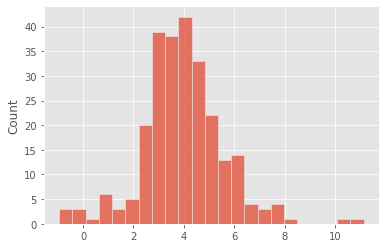

In [ ]:
sns.histplot(X)
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import kstest_normal


ks, pvalue = kstest_normal(X, dist='norm')
print('p-value:', pvalue)

p-value: 0.006303068369654561


In [ ]:
# дисперсия
np.var(X)

2.6594957703857585

Как построить доверительный интервал:
* нагенерируем новых выборок;
* оценим дисперсию на каждой;
* для полученной "выборки дисперсий" оценим квантили и построим доверительный интервал.

$X_1, X_2, ..., X_n$ -- выборка.

Эмпирическая функция распределения: $F_N^*(y) = \frac{1}{n}\sum\limits_{k=1}^n I(X_k < y)$.

In [ ]:
# построить гистограмму одного сэмплирования

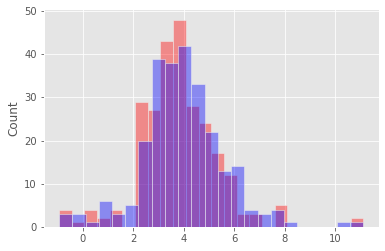

In [ ]:
Xb = np.random.choice(X, size=N)
sns.histplot(Xb, color='red', alpha=0.4)
sns.histplot(X, color='blue', alpha=0.4)
plt.show()

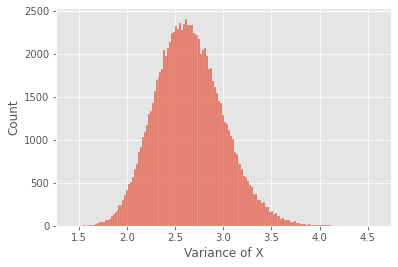

In [ ]:
M = 102400
var_list = []

for _ in range(M):
    Xb = np.random.choice(X, size=N)
    var = np.var(Xb)
    var_list.append(var)
    
sns.histplot(var_list)
plt.xlabel('Variance of X')
plt.show()

In [ ]:
ks, pvalue = kstest_normal(var_list, dist='norm')
pvalue

0.0009999999999998899

In [ ]:
alpha = 0.05

q0 = np.quantile(var_list, alpha / 2)
q1 = np.quantile(var_list, 1 - alpha / 2)

print(f'alpha-confidence interval: ({q0:.5f}, {q1:.5f})')

alpha-confidence interval: (2.01411, 3.39437)


# 2. Stacking

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [ ]:
from sklearn.preprocessing import LabelEncoder


frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000
frame['origin'] = LabelEncoder().fit_transform(frame['origin'])

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,2,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,2,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,2,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,2,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,2,ford torino


In [ ]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

In [ ]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit:', y_fit.shape)
print('Test:', y_test.shape)

Fit: (313,)
Test: (79,)


In [ ]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,8,5.030840,130.0,1.589386,12.0,70,2
1,8,5.735485,165.0,1.675115,11.5,70,2
2,8,5.211098,150.0,1.558542,11.0,70,2
3,8,4.981678,150.0,1.557181,12.0,70,2
4,8,4.948904,140.0,1.564439,10.5,70,2


In [ ]:
%%time
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_features),
    ('scaler', StandardScaler(), num_features)
])

estimator = LassoCV(n_alphas=64, precompute=True, 
                    cv=KFold(10, shuffle=True, random_state=42), 
                    random_state=42, n_jobs=1)
model_lasso = Pipeline([
    ('transformer', transformer),
    ('lasso', estimator)
], verbose=0)
model_lasso.fit(X_fit, y_fit)
regression_metrics(y_test, model_lasso.predict(X_test), verbose=True);

MAE:  0.9532266527580777
MSE:  1.5490485152380127
RMSE: 1.24460777566188
MAPE: 0.08465757739413263
R2:   0.8907564410581126

CPU times: total: 391 ms
Wall time: 926 ms


(0.9532266527580777,
 1.5490485152380127,
 1.24460777566188,
 0.08465757739413263,
 0.8907564410581126)

In [ ]:
%%time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_features),
    ('scaler', StandardScaler(), num_features)
])
estimator = SVR(C=1.0)
svr = Pipeline([
    ('transformer', transformer),
    ('svr', estimator)
], verbose=0)
model_svr = GridSearchCV(svr, {
        'svr__kernel': ('rbf', 'sigmoid', 'linear'),
        'svr__gamma': np.logspace(-3, 2, 8),
        'svr__C': np.logspace(1, 3, 4),
    }, verbose=0, n_jobs=-1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_svr.fit(X_fit, y_fit)
display(model_svr.best_estimator_)
regression_metrics(y_test, model_svr.predict(X_test), verbose=True);

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin']),
                                                 ('scaler', StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders',
                                                   'model_year'])])),
                ('svr', SVR(C=215.44346900318823, gamma=0.02682695795279726))],
         verbose=0)

MAE:  0.7945378649417608
MSE:  1.1051084836639145
RMSE: 1.0512414012318552
MAPE: 0.07296276043920989
R2:   0.9220644269144992

CPU times: total: 5.44 s
Wall time: 3min 1s


(0.7945378649417608,
 1.1051084836639145,
 1.0512414012318552,
 0.07296276043920989,
 0.9220644269144992)

In [ ]:
%%time
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(random_state=42)
model_tree = GridSearchCV(tree, dict(
        max_depth=(2, 5, 10, 20, 30),
        min_samples_leaf=(1, 5, 10, 15, 20),
    ), verbose=0, n_jobs=-1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_tree.fit(X_fit, y_fit)
display(model_tree.best_estimator_)

regression_metrics(y_test, model_tree.predict(X_test), verbose=True);

DecisionTreeRegressor(max_depth=5, random_state=42)

MAE:  1.1502366074816843
MSE:  2.27634965314718
RMSE: 1.508757652224896
MAPE: 0.10076744158164772
R2:   0.8394649779786145

CPU times: total: 516 ms
Wall time: 2.28 s


(1.1502366074816843,
 2.27634965314718,
 1.508757652224896,
 0.10076744158164772,
 0.8394649779786145)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(
    criterion='mse',
    max_depth=3,
    random_state=42,
    n_jobs=1
)
model_forest = GridSearchCV(forest, dict(
        n_estimators=(50, 100, 150),
        max_depth=(5, 10, 20, 30),
        min_samples_leaf=(1, 5, 10, 15),
    ), verbose=0, n_jobs=-1,
    cv=KFold(10, shuffle=True, random_state=42)
)
model_forest.fit(X_fit, y_fit)
display(model_forest.best_estimator_)

regression_metrics(y_test, model_forest.predict(X_test), verbose=True);

ValueError: 
All the 480 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
117 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'poisson', 'squared_error', 'absolute_error'}. Got 'mse' instead.

--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'absolute_error', 'friedman_mse', 'squared_error'}. Got 'mse' instead.

--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'absolute_error', 'friedman_mse', 'squared_error', 'poisson'}. Got 'mse' instead.

--------------------------------------------------------------------------------
133 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got 'mse' instead.


Пробуем стэкинг:

In [ ]:
%%time
from sklearn.ensemble import StackingRegressor


stacking = StackingRegressor([
        ('lasso', model_lasso), 
        ('tree', model_tree.best_estimator_), 
        ('svr', model_svr.best_estimator_),
        ('forest', model_forest.best_estimator_),
    ], verbose=1, n_jobs=-1,
    cv=KFold(313, shuffle=True, random_state=42)
)
stacking.fit(X_fit, y_fit)

regression_metrics(y_test, stacking.predict(X_test), verbose=True);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:   43.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE:  0.7887804159428745
MSE:  1.0844198556606202
RMSE: 1.041354817370439
MAPE: 0.07014841882182667
R2:   0.9235234511674338

CPU times: user 1min 9s, sys: 691 ms, total: 1min 10s
Wall time: 1min 46s


[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:   45.4s finished


(0.7887804159428745,
 1.0844198556606202,
 1.041354817370439,
 0.07014841882182667,
 0.9235234511674338)

# 3. Bagging

In [ ]:
%%time
from sklearn.ensemble import BaggingRegressor


bagging = BaggingRegressor(
    tree, 
    n_estimators=200, 
    bootstrap=True, 
    bootstrap_features=True, 
    n_jobs=-1, 
    random_state=42
)
bagging.fit(X_fit, y_fit)
regression_metrics(y_test, bagging.predict(X_test), verbose=True);

MAE:  0.8366039717297609
MSE:  1.319320782504243
RMSE: 1.1486168997991641
MAPE: 0.07422744654452318
R2:   0.9069575315111329

CPU times: total: 266 ms
Wall time: 660 ms


(0.8366039717297609,
 1.319320782504243,
 1.1486168997991641,
 0.07422744654452318,
 0.9069575315111329)

# 4. Boosting

In [ ]:
%%time
from sklearn.ensemble import AdaBoostRegressor


adaboost = AdaBoostRegressor(
    learning_rate=1.0, 
    random_state=42
)
model_adaboost = GridSearchCV(adaboost, dict(
    base_estimator=(
        DecisionTreeRegressor(max_depth=10, random_state=42),
        DecisionTreeRegressor(max_depth=5, random_state=42),
        DecisionTreeRegressor(max_depth=3, random_state=42),
    ),
    n_estimators=(100, 120, 130, 140, 150, 170, 200),
), n_jobs=-1, cv=KFold(10, shuffle=True, random_state=42))
model_adaboost.fit(X_fit, y_fit)
display(model_adaboost.best_estimator_)

regression_metrics(y_test, model_adaboost.predict(X_test), verbose=True);

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  n_estimators=130, random_state=42)

MAE:  0.7993545556571683
MSE:  1.1597379333675586
RMSE: 1.0769112931748643
MAPE: 0.07102511667073758
R2:   0.9182117938626894

CPU times: total: 1.64 s
Wall time: 49.5 s


(0.7993545556571683,
 1.1597379333675586,
 1.0769112931748643,
 0.07102511667073758,
 0.9182117938626894)

In [ ]:
%%time
from xgboost import XGBRegressor


xgb = XGBRegressor(
    n_jobs=1,
    random_state=42
)

model_xgb = GridSearchCV(xgb, {
        'n_estimators':(100, 130, 150, 170, 200),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        # 'booster': ['gbtree', 'gblinear', 'dart'],
    }, n_jobs=-1, verbose=10,
    cv=KFold(5, shuffle=True, random_state=42)
)
model_xgb.fit(X_fit, y_fit)
display(model_xgb.best_estimator_)

regression_metrics(y_test, model_xgb.predict(X_test), verbose=True);

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

MAE:  0.9265926283838263
MSE:  1.753348163988469
RMSE: 1.3241405378540712
MAPE: 0.08123599783238539
R2:   0.876348615544237

CPU times: user 4.33 s, sys: 141 ms, total: 4.47 s
Wall time: 13.6 s


(0.9265926283838263,
 1.753348163988469,
 1.3241405378540712,
 0.08123599783238539,
 0.876348615544237)